In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.formula.api import ols

In [25]:
# load data
data = pd.read_csv('all_params_w_utility768.csv', index_col=0)

In [26]:
data.head()

,score_change_repay,score_change_default,utility_default,potential_score_update_mode,agent,avg_max_unfairness_dp,avg_mean_unfairness_dp,initial_unfairness_dp,avg_max_unfairness_cs,avg_mean_unfairness_cs,initial_unfairness_cs,avg_total_utility,n_traces
0,8,-16,-10,equal,eqopp,0.253580,0.245492,0.241693,30.307973,29.437258,28.470233,47886.000000,7
1,12,-16,-10,equal,eqopp,0.252530,0.245727,0.241693,30.684186,29.723164,28.470233,49330.571429,7
2,16,-16,-10,equal,eqopp,0.251485,0.245390,0.241693,30.780589,29.800177,28.470233,49560.500000,8
3,20,-16,-10,equal,eqopp,0.251659,0.245605,0.241693,30.685030,29.791503,28.470233,48328.142857,7
4,8,-24,-10,equal,eqopp,0.256012,0.247783,0.241693,30.496072,29.554804,28.470233,46941.000000,7


In [27]:
data['max_increase_unfairness_dp'] = data['avg_max_unfairness_dp'] - data['initial_unfairness_dp']
data['avg_increase_unfairness_dp'] = data['avg_mean_unfairness_dp'] - data['initial_unfairness_dp']
data['max_increase_unfairness_cs'] = data['avg_max_unfairness_cs'] - data['initial_unfairness_cs']
data['avg_increase_unfairness_cs'] = data['avg_mean_unfairness_cs'] - data['initial_unfairness_cs']


In [28]:
# fit lm model with scaling
lm = ols(formula="max_increase_unfairness_dp ~ (scale(score_change_repay) +\
               scale(score_change_default) + potential_score_update_mode +\
               agent + scale(utility_default))**2", data=data).fit()

In [29]:
lm_params = lm.params
# renaming
lm_params = lm_params.rename({'potential_score_update_mode[T.large_var]' : 'Shift function - aggressive',
                            'potential_score_update_mode[T.small_var]' : 'Shift function - normal',
                            'agent[T.maxprof] '
                              'scale(score_change_repay)': 'score_change_repay', 
                              'scale(score_change_default)': 'score_change_default', 
                              'scale(utility_default)': 'utility_default'
                              }, axis=0)

In [30]:
print(lm.summary())

                                OLS Regression Results                                
Dep. Variable:     max_increase_unfairness_dp   R-squared:                       0.970
Model:                                    OLS   Adj. R-squared:                  0.969
Method:                         Least Squares   F-statistic:                     1194.
Date:                        Wed, 13 Nov 2024   Prob (F-statistic):               0.00
Time:                                12:21:56   Log-Likelihood:                 3519.2
No. Observations:                         768   AIC:                            -6996.
Df Residuals:                             747   BIC:                            -6899.
Df Model:                                  20                                         
Covariance Type:                    nonrobust                                         
                                                                           coef    std err          t      P>|t|      [0.025      

lm_stan.

In [40]:
# get the anova table
table = sm.stats.anova_lm(lm, typ=2)
table['eta_sq'] = table['sum_sq'] / table['sum_sq'].sum()

# remove residuals
table = table.iloc[:-1]

# get the ranking of the features based on sum of squares of anova table
table['sum_sq_rank'] = table['sum_sq'].rank(ascending=False)

# identify all variables p<=0.05
statistically_significant_variables = table[table['PR(>F)'] <= 0.05].index

In [12]:
table

,sum_sq,df,F,PR(>F),eta_sq,sum_sq_rank
potential_score_update_mode,7.256583e-06,2.0,0.575729,5.625440e-01,0.000047,11.0
agent,1.188103e-01,1.0,18852.558661,0.000000e+00,0.765218,1.0
potential_score_update_mode:agent,7.111949e-06,2.0,0.564254,5.690265e-01,0.000046,12.0
scale(score_change_repay),5.586836e-05,1.0,8.865066,3.000796e-03,0.000360,8.0
scale(score_change_repay):potential_score_update_mode,1.682149e-06,2.0,0.133460,8.750835e-01,0.000011,14.0
scale(score_change_repay):agent,5.578410e-05,1.0,8.851696,3.022594e-03,0.000359,9.0
scale(score_change_default),2.157481e-03,1.0,342.344187,3.305991e-63,0.013896,5.0
scale(score_change_default):potential_score_update_mode,8.508538e-07,2.0,0.067506,9.347280e-01,0.000005,15.0
scale(score_change_default):agent,2.159246e-03,1.0,342.624398,3.002351e-63,0.013907,4.0
scale(utility_default),1.353913e-02,1.0,2148.359432,5.876212e-222,0.087201,2.0


### Get sampling configuration of 2-coverage and 3-coverage

In [32]:
from covertable import make, sorters, criteria
X = data[['score_change_repay', 'score_change_default', 'utility_default', 'potential_score_update_mode','agent']]
score_change_repay_unique = X.score_change_repay.unique()
score_change_default_unique = X.score_change_default.unique()
utility_default_unique = X.utility_default.unique()
potential_score_update_mode_unique = X.potential_score_update_mode.unique()
agent_unique = X.agent.unique()

In [33]:
sample_2 = make([score_change_repay_unique,
               score_change_default_unique,
               utility_default_unique,
               potential_score_update_mode_unique,
               agent_unique],length=2)
sample_2 = [tuple(x) for x in sample_2]
sample_3 = make([score_change_repay_unique,
               score_change_default_unique,
               utility_default_unique,
               potential_score_update_mode_unique,
               agent_unique],length=3)
sample_3 = [tuple(x) for x in sample_3]
print(len(sample_2), len(sample_3), len(data))

33 135 768


In [34]:
sample_data_2 = data[data[['score_change_repay', 'score_change_default', 'utility_default', 'potential_score_update_mode','agent']].apply(tuple,1).isin(sample_2)]
sample_data_3 = data[data[['score_change_repay', 'score_change_default', 'utility_default', 'potential_score_update_mode','agent']].apply(tuple,1).isin(sample_3)]

In [35]:
sample_data_2.shape

(33, 17)

## Fit regression model for sampled data

In [36]:
# fit lm for 2-coverage sampling
lm_2 = ols(formula="max_increase_unfairness_dp ~ (scale(score_change_repay) +\
               scale(score_change_default) + potential_score_update_mode +\
               agent + scale(utility_default))**2", data=sample_data_2).fit()
# fit lm for 3-coverage sampling
lm_3 = ols(formula="max_increase_unfairness_dp ~ (scale(score_change_repay) +\
               scale(score_change_default) + potential_score_update_mode +\
               agent + scale(utility_default))**2", data=sample_data_3).fit()

In [37]:
# compute the MSE for original lm
mse = np.mean((lm.predict(data) - data['max_increase_unfairness_dp'])**2)
# compute the MSE for 2-coverage sampling lm
mse_2 = np.mean((lm_2.predict(data) - data['max_increase_unfairness_dp'])**2)
# compute the MSE for 3-coverage sampling lm
mse_3 = np.mean((lm_3.predict(data) - data['max_increase_unfairness_dp'])**2)

print(mse, mse_2, mse_3)

6.129757791149898e-06 1.6992953723766268e-05 6.5366225051961805e-06


In [38]:
from sklearn.metrics import r2_score
# compute the R2 for 3 lm
r2 = r2_score(data['max_increase_unfairness_dp'], lm_stan.predict(data))
r2_2 = r2_score(data['max_increase_unfairness_dp'], lm_2.predict(data))
r2_3 = r2_score(data['max_increase_unfairness_dp'], lm_3.predict(data))

print(r2, r2_2, r2_3)

0.9696795454439427 0.9159454421023734 0.9676670151787969


In [42]:
# get the anova table for 2-coverage sampling and 3-coverage sampling
table_2 = sm.stats.anova_lm(lm_2, typ=2)
table_3 = sm.stats.anova_lm(lm_3, typ=2)

# remove residuals
table_2 = table_2.iloc[:-1]
table_3 = table_3.iloc[:-1]

# get the ranking of the features based on sum of squares of anova table
table_2['sum_sq_rank'] = table_2['sum_sq'].rank(ascending=False)
table_3['sum_sq_rank'] = table_3['sum_sq'].rank(ascending=False)

## Compare the feature ranking between baseline and sampling

In [50]:
# compute Kendall Tau for significant variables
from scipy.stats import kendalltau
print(kendalltau(table.loc[statistically_significant_variables]['sum_sq_rank'], table_2.loc[statistically_significant_variables]['sum_sq_rank']))
print(kendalltau(table.loc[statistically_significant_variables]['sum_sq_rank'], table_3.loc[statistically_significant_variables]['sum_sq_rank']))

KendalltauResult(correlation=0.7777777777777778, pvalue=0.0024250440917107582)
KendalltauResult(correlation=0.8888888888888888, pvalue=0.00024250440917107584)


In [49]:
# compute Rank Biased Overlap
from rbo import rbo
# get the ranked features based on sum_sq_rank for statistically significant variables
ranked_features_gt_sig = table.loc[statistically_significant_variables].sort_values(by=['sum_sq_rank']).index.to_list()
ranked_features_2_sig = table_2.loc[statistically_significant_variables].sort_values(by=['sum_sq_rank']).index.to_list()
ranked_features_3_sig = table_3.loc[statistically_significant_variables].sort_values(by=['sum_sq_rank']).index.to_list()

# compute Rank Biased Overlap
print(rbo.RankingSimilarity(ranked_features_gt_sig, ranked_features_2_sig).rbo_ext(p=0.8))
print(rbo.RankingSimilarity(ranked_features_gt_sig, ranked_features_3_sig).rbo_ext(p=0.8))

0.913320838095238
0.9669101714285715


## Trade-off Analysis

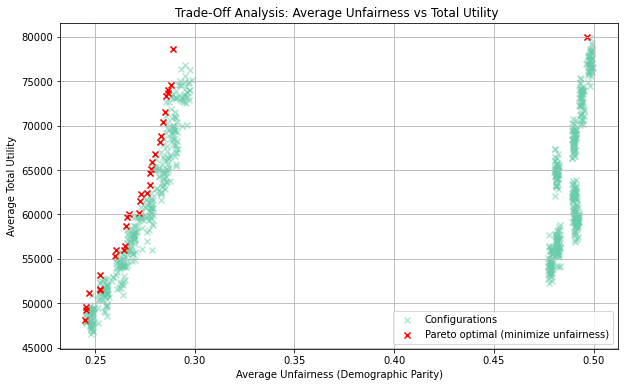

In [25]:
# Adjusting the Pareto efficiency function for the new criteria
def is_pareto_efficient_minimize_cost(costs, returns):
    """
    Identify the Pareto efficient points for minimizing costs and maximizing returns
    :param costs: An array of costs to minimize
    :param returns: An array of returns to maximize
    :return: A boolean array, where True indicates Pareto efficiency
    """
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.logical_not(np.logical_and(returns[is_efficient] <= returns[i], costs[is_efficient] >= c))
            is_efficient[i] = True  # And keep self
    return is_efficient

pareto_minimize_cost = is_pareto_efficient_minimize_cost(data['avg_mean_unfairness_dp'].values, data['avg_total_utility'].values)

# Re-plotting the data with updated Pareto optimal points
plt.figure(figsize=(10, 6))
plt.scatter(data['avg_mean_unfairness_dp'], data['avg_total_utility'], alpha=0.5, label='Configurations', marker='x', color='mediumaquamarine')
plt.scatter(data['avg_mean_unfairness_dp'][pareto_minimize_cost], data['avg_total_utility'][pareto_minimize_cost], color='r', marker='x', label='Pareto optimal (minimize unfairness)')
plt.title('Trade-Off Analysis: Average Unfairness vs Total Utility ')
plt.xlabel('Average Unfairness (Demographic Parity)')
plt.ylabel('Average Total Utility')
plt.grid()
plt.legend()


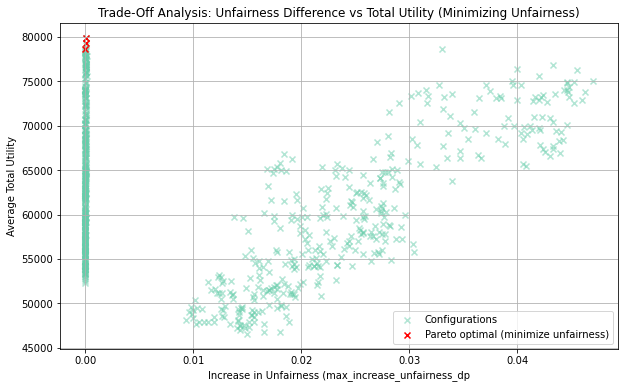

In [26]:

pareto_minimize_cost = is_pareto_efficient_minimize_cost(data['max_increase_unfairness_dp'].values, data['avg_total_utility'].values)

# Re-plotting the data with updated Pareto optimal points
plt.figure(figsize=(10, 6))
plt.scatter(data['max_increase_unfairness_dp'], data['avg_total_utility'], alpha=0.5, label='Configurations', marker='x', color='mediumaquamarine')
plt.scatter(data['max_increase_unfairness_dp'][pareto_minimize_cost], data['avg_total_utility'][pareto_minimize_cost], color='r', marker='x', label='Pareto optimal (minimize unfairness)')
plt.title('Trade-Off Analysis: Unfairness Difference vs Total Utility (Minimizing Unfairness)')
plt.xlabel('Increase in Unfairness (max_increase_unfairness_dp')
plt.ylabel('Average Total Utility')
plt.grid()
plt.legend()

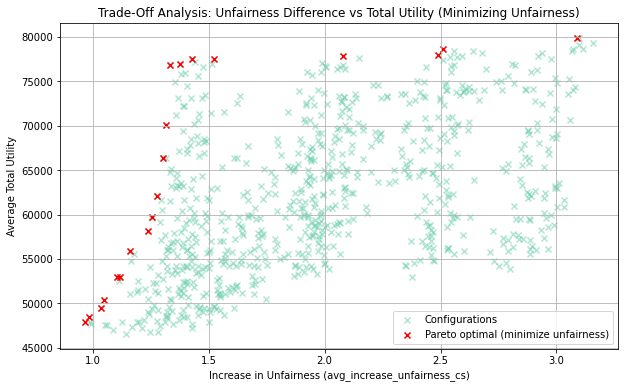

In [27]:
pareto_minimize_cost_cs = is_pareto_efficient_minimize_cost(data['avg_increase_unfairness_cs'].values, data['avg_total_utility'].values)

# Re-plotting the data with updated Pareto optimal points
plt.figure(figsize=(10, 6))
plt.scatter(data['avg_increase_unfairness_cs'], data['avg_total_utility'], alpha=0.5, label='Configurations', marker='x', color='mediumaquamarine')
plt.scatter(data['avg_increase_unfairness_cs'][pareto_minimize_cost_cs], data['avg_total_utility'][pareto_minimize_cost_cs], color='r', marker='x', label='Pareto optimal (minimize unfairness)')
plt.title('Trade-Off Analysis: Unfairness Difference vs Total Utility (Minimizing Unfairness)')
plt.xlabel('Increase in Unfairness (avg_increase_unfairness_cs)')
plt.ylabel('Average Total Utility')
plt.grid()
plt.legend()

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import pi
from sklearn.preprocessing import MinMaxScaler

def plot_spider_chart(df, features, path=None):
    # Number of variables we're plotting.
    num_vars = len(features)

    # Compute angle each bar is centered on:
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is circular, so we need to "complete the loop" and append the start to the end.
    angles += angles[:1]

    sns.set_context('paper', font_scale=1.4)

    # Initialize the spider plot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # Draw one axe per variable and add labels
    plt.xticks(angles[:-1], features, size=20)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=15)
    plt.ylim(0, 1)

    line_styles = ['solid', (0, (5, 10)),'dotted', (5, (10, 3)), 'dashdot']  # List of line styles

    i = 0
    for idx, row in df.iterrows():
        values = row.values.flatten().tolist()
        values += values[:1]
        line_style = line_styles[i % len(line_styles)]  # Get the line style based on the index
        ax.plot(angles, values, linewidth=1, linestyle=line_style, label=f'Config {idx}')
        ax.fill(angles, values, alpha=0.1)
        i += 1


    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    if path:
        plt.savefig(path, format="pdf", bbox_inches="tight")


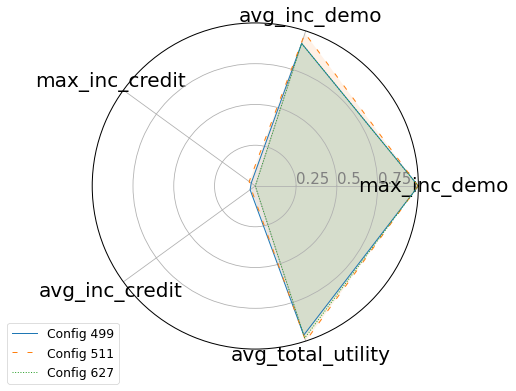

In [31]:
scaler = MinMaxScaler()
features = ['max_increase_unfairness_dp', 'avg_increase_unfairness_dp', 'max_increase_unfairness_cs', 'avg_increase_unfairness_cs', 'avg_total_utility']
df_normalized = pd.DataFrame(scaler.fit_transform(data[features]), 
                             columns=features)
for f in features[:4]:
    df_normalized[f] = 1 - df_normalized[f]
new_feature_names = ['max_inc_demo', 'avg_inc_demo', 'max_inc_credit', 'avg_inc_credit', 'avg_total_utility']
df_normalized.columns = new_feature_names
pareto_data_features = df_normalized[pareto_minimize_cost]
plot_spider_chart(pareto_data_features, new_feature_names, './radar.pdf')

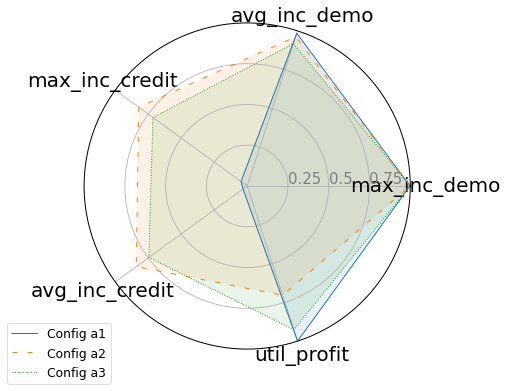

In [32]:
two_pareto_index = [511, 620, 624]

scaler = MinMaxScaler()
features = ['max_increase_unfairness_dp', 'avg_increase_unfairness_dp', 'max_increase_unfairness_cs', 'avg_increase_unfairness_cs', 'avg_total_utility']
df_normalized = pd.DataFrame(scaler.fit_transform(data[features]), 
                             columns=features)
for f in features[:4]:
    df_normalized[f] = 1 - df_normalized[f]
new_feature_names = ['max_inc_demo', 'avg_inc_demo', 'max_inc_credit', 'avg_inc_credit', 'util_profit']
df_normalized.columns = new_feature_names
pareto_data_features = df_normalized.loc[two_pareto_index]
# rename index as a,b,c
pareto_data_features.index = ['a1', 'a2', 'a3']
plot_spider_chart(pareto_data_features, new_feature_names, './radar_new.pdf')